In [5]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import pandas as pd
import time, sys, os

# short decision tree

train mse: 15.38


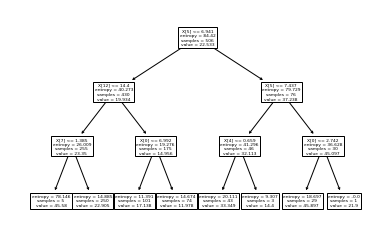

In [11]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# load in same data
boston_data = pd.read_csv("data/boston.csv", index_col=0)
y = boston_data.medv.values
X = boston_data.drop("medv", axis=1)
features = X.columns
X = X.values

# specify a decision tree with a maximum depth
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X, y)

# calculat mse on the training data
preds = dt.predict(X)
print(f'train mse: {np.mean(np.square(preds-y)):0.2f}')

plot_tree(dt)
plt.savefig('tree.pdf')
plt.show()

# integer linear models

In [11]:
def fit_integer_linear_model(X, y, lambda_reg=0):
    import cvxpy # package for optimization
    '''fit a linear model with integer coefficient and L1 regularizaiton'''
    
    # declare the integer-valued optimization variable
    w = cvxpy.Variable(X.shape[1], integer=True)

    # set up the minimization problem
    obj = cvxpy.Minimize(cvxpy.norm(X * w - y, 2) + lambda_reg * cvxpy.norm(w, 1))
    prob = cvxpy.Problem(obj)

    # solve the problem using an appropriate solver
    sol = prob.solve(solver = 'ECOS_BB')

    # the optimal value
    return w.value.astype(np.int)


np.random.seed(123)

# generate X and y
n, p = 1000, 10
X = np.random.randn(n, p)
y = X[:, 0] + 2 * X[:, 1] - 1 * X[:, 2] + np.random.randn(n)

# fit linear models with different regularization parameters
for lambda_reg in [0, 1e-2, 5e-2, 1e-1, 1, 2]:
    w = fit_integer_linear_model(X, y, lambda_reg)
    mse = np.mean(np.square(y - X @ w))
    print(f'{lambda_reg}\tmse: {mse: 0.2f}\t{w}')

0	mse:  2.09	[ 1  1 -1  0  0  0  0  0  0  0]
0.01	mse:  2.09	[ 1  1 -1  0  0  0  0  0  0  0]
0.05	mse:  1.02	[ 1  2 -1  0  0  0  0  0  0  0]
0.1	mse:  1.02	[ 1  2 -1  0  0  0  0  0  0  0]
1	mse:  3.08	[ 0  1 -1  0  0  0  0  0  0  0]
2	mse:  1.90	[ 0  2 -1  0  0  0  0  0  0  0]


# rulefit
- installed with: `pip install git+git://github.com/christophM/rulefit.git`
- some docs: `https://github.com/christophM/rulefit`
- original paper: `http://statweb.stanford.edu/~jhf/ftp/RuleFit.pdf`

In [12]:
from rulefit import RuleFit

# load some data
boston_data = pd.read_csv("data/boston.csv", index_col=0)
y = boston_data.medv.values
X = boston_data.drop("medv", axis=1)
features = X.columns
X = X.values

# fit a rulefit model
rf = RuleFit()
rf.fit(X, y, feature_names=features)

# calculate mse on the training data
preds = rf.predict(X)
print(f'train mse: {np.mean(np.square(preds-y)):0.2f}')

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1380639069759013, tolerance: 2.11691609495549
  positive)


train mse: 1.45


/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.6116729084955, tolerance: 4.2716295415019765
  positive)


now, let's inspect the rules

In [17]:
rules = rf.get_rules()

rules = rules[rules.coef != 0].sort_values("support", ascending=False)

# 'rule' is how the feature is constructed
# 'coef' is its weight in the final linear model
# 'support' is how many points it applies to
rules[['rule', 'coef', 'support']].head().style.background_gradient(cmap='viridis')

,rule,coef,support
1,zn,0.00336756,1
6,age,-0.0303105,1
1161,crim <= 24.719950675964355,0.0383167,0.978632
1469,rm > 4.990999937057495 & rm <= 8.742000102996826 & lstat <= 26.729999542236328,0.306809,0.940171
996,rm <= 7.479499816894531 & tax > 204.5,-0.75093,0.940171


# scalable bayesian rule lists (in C)
- docs at `https://github.com/myaooo/pysbrl`
- requires installing some `c` packages (ex. instructions [here](https://coral.ise.lehigh.edu/jild13/2016/07/11/hello/))
- note: input format is pretty strange (it is sensible in [R](https://rdrr.io/cran/sbrl/man/sbrl.html))
- only works with categorical variables (continuous must be discretized somehow)
- there is another implementation in the [skater](https://oracle.github.io/Skater/install.html) package as well

In [25]:
# this example has categorical variables c1, c2, ... that take on values 'o', 'x', 'b'
import pysbrl

rule_ids, outputs, rule_strings = pysbrl.train_sbrl("data/train.out", 
                                                    "data/train.label", 
                                                    20.0, eta=2.0, max_iters=2000)

class_num = 1
for i, rule_id in enumerate(rule_ids):
    prefix = 'if' if i == 0 else 'elif' if i < len(rule_ids) -1 else ''
    print(prefix, rule_strings[rule_id] + f': {outputs[i, class_num]:0.2f}')

if {c4=o,c5=o,c6=o}: 0.04
elif {c1=x,c7=x}: 0.86
elif {c5=x,c7=o,c9=o}: 0.58
elif {c1=x,c2=x,c3=x}: 0.98
elif {c5=o,c9=o}: 0.02
elif {c1=o,c2=o,c3=o}: 0.04
elif {c3=x,c4=b,c9=x}: 0.93
elif {c7=o,c9=o}: 0.08
elif {c1=x,c2=b,c3=x}: 0.88
elif {c5=o,c7=o}: 0.17
elif {c6=o,c9=o}: 0.43
elif {c4=x,c5=o}: 0.33
elif {c1=o,c4=o,c7=o}: 0.05
 default: 0.98


# optimal classification tree
- docs here: `https://github.com/pan5431333/pyoptree`
- note: this implementation is still slightly unstable, and requires either `cplex` or `gurobi` to be installed

In [ ]:
from pyoptree.optree import OptimalHyperTreeModel, OptimalTreeModel

data = pd.DataFrame({
    "index": ['A', 'C', 'D', 'E', 'F'],
    "x1": [1, 2, 2, 2, 3],
    "x2": [1, 2, 1, 0, 1],
    "y": [1, 1, 0, 0, 0]
})
test_data = pd.DataFrame({
    "index": ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
    "x1": [1, 1, 2, 2, 2, 3, 3],
    "x2": [1, 2, 2, 1, 0, 1, 0],
    "y": [1, 1, 1, 0, 0, 0, 0]
})
model = OptimalHyperTreeModel(["x1", "x2"], "y", tree_depth=2, N_min=1, alpha=0.1, solver_name="cplex")
model.train(data, train_method="mio")

print(model.predict(test_data))